# COVID-19 Forecasting with Smoothing Methods

This notebook investigates how different **smoothing techniques** influence the performance of time-series forecasting models for COVID-19 new cases.  
The goal is to evaluate whether preprocessing by smoothing can improve the short-term (3-month) and medium-term (6-month) predictive accuracy across countries.

### **Objectives**
- Compare four smoothing methods: **Moving Average**, **STL decomposition**, **Exponentially Weighted Moving Average (EWMA)**, and **Kalman Filter**.  
- Evaluate how each method affects the predictive performance of models including **LSTM**, **Temporal Fusion Transformer (TFT)**, **XGBoost**, and **LightGBM**.  
- Assess results using standard error metrics — **MAE**, **RMSE**, and **MAPE**.  
- Explore model generalization across countries using WHO COVID-19 datasets.

### **Motivation**
Time-series forecasting during the COVID-19 pandemic presents significant challenges due to noise, missing data, and non-stationarity.  
Smoothing methods can mitigate these issues by reducing random fluctuations while preserving long-term patterns.  
This experiment aims to provide a systematic comparison of such preprocessing techniques to identify which approach yields the most robust forecasts.

### **Data Source**
- **World Health Organization (WHO) COVID-19 Dashboard:** [https://data.who.int/dashboards/covid19/data](https://data.who.int/dashboards/covid19/data)  
- Contains daily confirmed cases and deaths reported by country and region (2020–2024).  
- Data were cleaned and aggregated by country, with normalization per population where applicable.  
- Train/validation/test split: **80% / 10% / 10%** by chronological order.  
- The dataset is publicly available under WHO’s open data access policy.
  
### **Models Evaluated**
| Model | Type | Framework |
|-------|------|------------|
| LSTM | Neural network | PyTorch |
| TFT | Hybrid deep model | PyTorch Forecasting |
| XGBoost | Tree ensemble | scikit-learn / xgboost |
| LightGBM | Tree ensemble | lightgbm |


In [1]:
# =====================================
# 📦 General Setup
# =====================================
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import logging
import random
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
logging.disable(logging.CRITICAL)

# =====================================
# ⚙️ Reproducibility
# =====================================
import torch
from lightning.pytorch import seed_everything

seed = 42
seed_everything(seed, workers=True)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# =====================================
# 📈 Data Preprocessing
# =====================================
from sklearn.preprocessing import QuantileTransformer
from statsmodels.tsa.seasonal import STL
from scipy.stats import kruskal
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pykalman import KalmanFilter

# =====================================
# 🧠 Models
# =====================================
import xgboost as xgb
import lightgbm as lgb

# PyTorch Forecasting
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger


# =====================================
# 🪶 Darts Framework
# =====================================
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel, RNNModel
from darts.metrics import mae, rmse, mape
from darts.utils.likelihood_models import QuantileRegression

# =====================================
# 🧮 Evaluation Metrics
# =====================================
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# =====================================
# 🧰 Notebook Utilities
# =====================================
%matplotlib inline


## Feature Engineering

This section defines helper functions for generating lag-based and statistical features from the COVID-19 time series.

### `add_lag_features(df)`
Creates a rich set of lagged and rolling-window features:
- **Lag features:** 1, 2, 3, 7, 14, 21, 28, 32, 44, 60, 90 days.
- **Rolling statistics:** mean, standard deviation, min, max over 7, 14, and 28-day windows.
- **Percentage change:** 1-day and 7-day percent changes (with clipping to prevent outliers).
- **STL decomposition:** trend, seasonal, and residual components.
- Missing values are filled using backward and forward filling.

### `prepare_data_with_features(df, country, split_data)`
Performs the following steps:
1. Cleans and filters the WHO dataset for a selected country.  
2. Resamples data to weekly frequency (`W-Mon`).  
3. Clips negative values and replaces missing data.  
4. Generates lag and statistical features via `add_lag_features()`.  
5. Splits the dataset into train/test sets by date (`split_data`).  
6. Creates **Darts TimeSeries** objects for both target (`New_cases`) and covariates.  

The resulting objects are used as input for forecasting models such as **TFT**, **LSTM**, **XGBoost**, and **LightGBM**.


In [2]:
# Feature Engineering Function
def add_lag_features(df):
    """
    Add comprehensive lag features to a DataFrame with COVID data.
    """
    result = df.copy()
    lags = [1, 2, 3, 7, 14, 21, 28, 32, 44, 60, 90]
    for lag in lags:
        result[f'lag_new_cases_{lag}'] = result['New_cases'].shift(lag)

    windows = [7, 14, 28]
    for window in windows:
        result[f'ma_new_cases_{window}'] = result['New_cases'].rolling(window=window).mean()
        result[f'std_new_cases_{window}'] = result['New_cases'].rolling(window=window).std()
        result[f'min_new_cases_{window}'] = result['New_cases'].rolling(window=window).min()
        result[f'max_new_cases_{window}'] = result['New_cases'].rolling(window=window).max()
    safe_cases = result['New_cases'].replace(0, 0.0001)
    result['pct_change_1d'] = safe_cases.pct_change(periods=1).clip(-10, 10)
    result['pct_change_7d'] = safe_cases.pct_change(periods=7).clip(-10, 10)
    try:
        stl = STL(result['New_cases'], period=7)
        res = stl.fit()
        result['trend'] = res.trend
        result['seasonal'] = res.seasonal
        result['residual'] = res.resid
    except Exception as e:
        print(f"STL Decomposition Error: {e}")

    result = result.fillna(method='bfill').fillna(method='ffill').fillna(0)
    return result


def prepare_data_with_features(df, country, split_data):


    df['Date_reported'] = pd.to_datetime(df['Date_reported'])
    df['Country_code'].fillna('Unknown', inplace=True)
    df['New_cases'].fillna(0, inplace=True)  
    df['New_deaths'].fillna(0, inplace=True)

    # Clip negative values
    df['New_cases'] = df['New_cases'].clip(lower=0)
    df['New_deaths'] = df['New_deaths'].clip(lower=0)

    df = df[df['Country'] == country].reset_index(drop=True).drop(columns=['Country_code', 'Country', 'WHO_region'])
    df = df.set_index('Date_reported')  # Set Date_reported as index
    df = df.resample('W-Mon').sum().reset_index()  # Resample on the new index

    def set_index(df):
        df['Date_reported'] = pd.to_datetime(df['Date_reported'], infer_datetime_format=True).dt.tz_localize(None)
        df.set_index(keys='Date_reported', inplace=True, drop=True)
        return df

  
    train_data = set_index(df[df["Date_reported"] < split_data])
    test_data = set_index(df[df["Date_reported"] >= split_data])
    all_data = set_index(df)

    new_cases_features = add_lag_features(all_data[['New_cases']])

    # Merge lagged features back with the original data
    full_data_with_features = pd.concat([all_data[['Cumulative_cases', 'New_deaths', 'Cumulative_deaths']], new_cases_features], axis=1)

    train_data_with_features = full_data_with_features.loc[train_data.index]
    test_data_with_features = full_data_with_features.loc[test_data.index]
    all_data_with_features = full_data_with_features.loc[all_data.index]
    
    # Create TimeSeries objects without log transformation
    train_data_times = TimeSeries.from_series(train_data_with_features['New_cases']).astype(np.float32)
    test_data_times = TimeSeries.from_series(test_data_with_features['New_cases']).astype(np.float32)
    all_data_times = TimeSeries.from_series(all_data_with_features['New_cases']).astype(np.float32)
    
    # Covariates remain unchanged
    train_covariates = TimeSeries.from_dataframe(train_data_with_features.drop(columns=['New_cases'])).astype(np.float32)
    test_covariates = TimeSeries.from_dataframe(test_data_with_features.drop(columns=['New_cases'])).astype(np.float32)
    all_covariates = TimeSeries.from_dataframe(all_data_with_features.drop(columns=['New_cases'])).astype(np.float32)
    
    return train_data_times, test_data_times, all_data_times, train_covariates, test_covariates, all_covariates

## Temporal Fusion Transformer (TFT) Model

This section defines a **Temporal Fusion Transformer (TFT)** for forecasting weekly COVID-19 cases using lag features, rolling statistics, and STL-based covariates.

### `tft_model(df, split_date, country, input_chunk_length, forecast_horizon)`

**Pipeline Overview:**
1. **Data Preparation:**  
   - Builds lag and rolling covariates using `prepare_data_with_features()`.  
   - Scales target and covariates with `QuantileTransformer` (normal distribution).  

2. **Model Configuration:**  
   - Based on **Darts’ TFTModel** combining LSTM encoder–decoder and attention.  
   - Key parameters:  
     - `hidden_size=256`, `lstm_layers=4`, `num_attention_heads=4`, `dropout=0.2`  
     - `hidden_continuous_size=64`, learning rate `0.001`  
     - Quantile regression with `[0.1, 0.25, 0.5, 0.75, 0.9]`  
   - Includes **EarlyStopping**, **LearningRateMonitor**, and **TensorBoardLogger**.  

3. **Training and Evaluation:**  
   - Trains on scaled series with future covariates; uses early stopping for stability.  
   - Evaluates predictions on the original scale using **MAPE**, **MAE**, and **RMSE**, with `epsilon` to prevent division by zero.

**Returns:**  
`pred_tft, mape_score, mae_score, rmse_score`


In [3]:
def tft_model(df, split_data, country, input_chunk_length, forecast_horizon):
    """
    Train and evaluate a Temporal Fusion Transformer (TFT) model
    for COVID-19 case forecasting on WHO data.
    """

    # Prepare data and covariates
    train_data_times, test_data_times, _, train_covariates, _, all_covariates = \
        prepare_data_with_features(df, country, split_data)

    # Scaling with QuantileTransformer
    quantile_scaler = QuantileTransformer(output_distribution='normal')

    scaler_target = Scaler(quantile_scaler)
    train_data_times_scaled = scaler_target.fit_transform(train_data_times)
    test_data_times_scaled = scaler_target.transform(test_data_times)

    scaler_covs = Scaler(quantile_scaler)
    scaler_covs.fit(train_covariates)
    all_covariates_scaled = scaler_covs.transform(all_covariates)

    # Callbacks and logging
    tensorboard_logger = TensorBoardLogger(save_dir="logs", name="tft_model")
    lr_logger = LearningRateMonitor()
    early_stopping = EarlyStopping(
        monitor="train_loss",
        patience=10,
        min_delta=0.0005,
        verbose=True
    )

    # Model setup
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

    tft = TFTModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=forecast_horizon,
        hidden_size=256,
        lstm_layers=4,
        num_attention_heads=4,
        hidden_continuous_size=64,
        dropout=0.2,
        batch_size=32,
        n_epochs=100,
        add_relative_index=True,
        likelihood=QuantileRegression(quantiles=quantiles),
        optimizer_kwargs={"lr": 0.001},
        random_state=seed,
        force_reset=True,
        pl_trainer_kwargs={
            "precision": "32-true",
            "logger": tensorboard_logger,
            "callbacks": [lr_logger, early_stopping],
            "log_every_n_steps": 10,
            "gradient_clip_val": 0.1,
        }
    )

    # Fit model
    tft.fit(
        series=train_data_times_scaled,
        future_covariates=all_covariates_scaled,
        verbose=True
    )

    # Evaluation
    num_samples = 200

    def eval_model(model, n, test_series, epsilon=1e-10):
        pred_scaled = model.predict(n=n, num_samples=num_samples)
        pred = scaler_target.inverse_transform(pred_scaled)
        true = scaler_target.inverse_transform(test_series)

        # Avoid division-by-zero
        true = true + epsilon
        pred = pred + epsilon

        mape_value = mape(true, pred)
        mae_value = mae(true, pred)
        rmse_value = rmse(true, pred)
        return pred, mape_value, mae_value, rmse_value

    pred_tft, mape_score, mae_score, rmse_score = eval_model(
        tft, len(test_data_times_scaled), test_data_times_scaled
    )

    return pred_tft, mape_score, mae_score, rmse_score


## Long Short-Term Memory (LSTM) Model

This section defines an **LSTM-based** model for forecasting weekly COVID-19 cases using temporal patterns from lagged and covariate features.

### `lstm_model(df, split_date, country, training_length, input_chunk_length)`

**Pipeline Overview:**
1. **Data Preparation:**  
   - Builds lag and rolling features using `prepare_data_with_features()`.  
   - Scales target and covariates via `QuantileTransformer`.  

2. **Model Configuration:**  
   - Implemented via Darts’ `RNNModel` with the LSTM architecture.  
   - Key settings:  
     - `hidden_dim=256`, `n_rnn_layers=8`, `dropout=0.1`, `batch_size=32`  
     - `n_epochs=300`, learning rate `0.001`, gradient clipping `0.1`  
     - Quantile regression with `[0.1, 0.25, 0.5, 0.75, 0.9]`  
   - Includes callbacks: **EarlyStopping**, **LearningRateMonitor**, and **TensorBoardLogger**.  

3. **Training and Evaluation:**  
   - Trains on scaled data with covariates and predicts on the test set.  
   - Evaluates predictions using **MAPE**, **MAE**, and **RMSE**, with `epsilon` for numerical stability.

**Returns:**  
`pred_lstm, mape_score, mae_score, rmse_score`


In [5]:
def lstm_model(df, split_date, country, training_length, input_chunk_length):
    """
    Train and evaluate an LSTM model for COVID-19 case forecasting using WHO data.
    """

    # Prepare data and covariates
    train_data_times, test_data_times, _, train_covariates, _, all_covariates = \
        prepare_data_with_features(df, country, split_date)

    # Scaling with QuantileTransformer
    quantile_scaler = QuantileTransformer(output_distribution='normal')

    scaler_target = Scaler(quantile_scaler)
    train_data_times_scaled = scaler_target.fit_transform(train_data_times)
    test_data_times_scaled = scaler_target.transform(test_data_times)

    scaler_covs = Scaler(quantile_scaler)
    scaler_covs.fit(train_covariates)
    all_covariates_scaled = scaler_covs.transform(all_covariates)

    # Logging and callbacks
    tensorboard_logger = TensorBoardLogger(save_dir="logs", name="lstm_model")
    lr_logger = LearningRateMonitor()
    early_stopping = EarlyStopping(
        monitor="train_loss",
        patience=10,
        min_delta=0.0005,
        verbose=True
    )

    # Model configuration
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

    lstm = RNNModel(
        model="LSTM",
        hidden_dim=256,
        n_rnn_layers=8,
        dropout=0.1,
        batch_size=32,
        n_epochs=300,
        optimizer_kwargs={"lr": 0.001},
        model_name="Covid_RNN",
        random_state=seed,
        training_length=training_length,
        input_chunk_length=input_chunk_length,
        likelihood=QuantileRegression(quantiles=quantiles),
        log_tensorboard=True,
        force_reset=True,
        save_checkpoints=True,
        pl_trainer_kwargs={
            "precision": "32-true",
            "logger": tensorboard_logger,
            "callbacks": [lr_logger, early_stopping],
            "log_every_n_steps": 10,
            "gradient_clip_val": 0.1,
        }
    )

    # Train model
    lstm.fit(
        series=train_data_times_scaled,
        future_covariates=all_covariates_scaled,
        verbose=True
    )

    # Evaluation

    def eval_model(model, n, test_series, epsilon=1e-10):
        pred_scaled = model.predict(n=n)
        pred = scaler_target.inverse_transform(pred_scaled)
        true = scaler_target.inverse_transform(test_series)

        true = true + epsilon
        pred = pred + epsilon

        mape_value = mape(true, pred)
        mae_value = mae(true, pred)
        rmse_value = rmse(true, pred)
        return pred, mape_value, mae_value, rmse_value

    pred_lstm, mape_score, mae_score, rmse_score = eval_model(
        lstm, len(test_data_times_scaled), test_data_times_scaled
    )

    return pred_lstm, mape_score, mae_score, rmse_score


## Feature Engineering for XGBoost and LightGBM

This section defines preprocessing utilities for tree-based models, generating time-dependent features from COVID-19 case data.

### `add_lag_features_xgboost(df)`
Creates lagged and statistical features to capture temporal dependencies:
- **Lag features:** shifts by 1, 2, 3, 7, 14, 21, 28, 32, 44, 60, 90 days.  
- **Rolling stats:** mean, std, min, max over 7-, 14-, and 28-day windows.  
- **Percent changes:** daily and weekly relative variations (clipped).  
- **STL decomposition:** adds trend, seasonal, and residual components.  
- Missing values are filled both backward and forward.

**Returns:**  
`X` — feature matrix, `y` — target variable (`New_cases`)

### `create_dataset(df, country, split_date)`
Generates weekly-aggregated, cleaned subsets for model training and testing:
1. Parses dates and fills missing values.  
2. Removes negative values and aggregates data weekly (`W-Mon`).  
3. Splits the dataset chronologically into train/test partitions based on `split_date`.


In [6]:
# =====================================
# Feature Engineering for XGBoost
# =====================================

def add_lag_features_xgboost(df):
    """
    Create lag and rolling statistical features for XGBoost training.
    """
    result = df.copy()

    # Lag features
    lags = [1, 2, 3, 7, 14, 21, 28, 32, 44, 60, 90]
    for lag in lags:
        result[f'lag_new_cases_{lag}'] = result['New_cases'].shift(lag)

    # Rolling window statistics
    windows = [7, 14, 28]
    for window in windows:
        result[f'ma_new_cases_{window}'] = result['New_cases'].rolling(window).mean()
        result[f'std_new_cases_{window}'] = result['New_cases'].rolling(window).std()
        result[f'min_new_cases_{window}'] = result['New_cases'].rolling(window).min()
        result[f'max_new_cases_{window}'] = result['New_cases'].rolling(window).max()

    # Percentage change features
    safe_cases = result['New_cases'].replace(0, 0.0001)
    result['pct_change_1d'] = safe_cases.pct_change(periods=1).clip(-10, 10)
    result['pct_change_7d'] = safe_cases.pct_change(periods=7).clip(-10, 10)

    # STL decomposition
    try:
        stl = STL(result['New_cases'], period=7)
        res = stl.fit()
        result['trend'] = res.trend
        result['seasonal'] = res.seasonal
        result['residual'] = res.resid
    except Exception as e:
        print(f"STL decomposition error: {e}")

    # Handle missing values
    result = result.fillna(method='bfill').fillna(method='ffill').fillna(0)

    X = result.drop(columns=['New_cases'])
    y = result['New_cases']
    return X, y


def create_dataset(df, country, split_date):
    """
    Prepare country-level training and test datasets for XGBoost.
    """
    df = df.copy()
    df['Date_reported'] = pd.to_datetime(df['Date_reported'])

    # Clean and preprocess
    df['Country_code'].fillna('Unknown', inplace=True)
    df['New_cases'] = df['New_cases'].fillna(0).clip(lower=0)
    df['New_deaths'] = df['New_deaths'].fillna(0).clip(lower=0)

    # Filter by country and aggregate weekly
    df = (
        df[df['Country'] == country]
        .drop(columns=['Country_code', 'Country', 'WHO_region'])
        .set_index('Date_reported')
        .resample('W-Mon').sum().reset_index()
    )

    # Split train/test by date
    train_df = df[df['Date_reported'] < split_date]
    test_df = df[df['Date_reported'] >= split_date]

    return train_df, test_df


## XGBoost Model

This section describes the **XGBoost** regressor for forecasting weekly COVID-19 new cases using lag and rolling statistical features.

### `xgboost_model(df, country, split_date)`

**Overview:**
1. **Data Preparation:**  
   - Builds country-specific weekly train/test sets (`create_dataset()`).
   - Extracts lag and rolling features (`add_lag_features_xgboost()`).

2. **Preprocessing:**  
   - Drops the `Date_reported` column and applies **QuantileTransformer** to scale inputs and targets.

3. **Training:**  
   - Converts data into **DMatrix** format.  
   - Objective: `reg:squarederror`, evaluation: `rmse`.  
   - Main parameters: `max_depth=8`, `eta=0.2`, `subsample=0.8`, `colsample_bytree=0.8`, `num_boost_round=100`.

4. **Prediction and Evaluation:**  
   - Predictions are inverse-scaled to original values.  
   - Metrics: **RMSE**, **MAE**, **MAPE**.

**Returns:**  
`y_pred, mape, mae, rmse`


In [7]:
def xgboost_model(df, country, split_date):     
    """
    XGBoost model for COVID-19 forecasting using lagged and rolling features.
    Feature scaling is done with QuantileTransformer for stability.
    """

    # 1. Prepare data
    train_data, test_data = create_dataset(df, country, split_date)
    X_train, y_train = add_lag_features_xgboost(train_data)
    X_test, y_test2 = add_lag_features_xgboost(test_data)
    y_test = y_test2 + 1e-10

    # 2. Drop unnecessary columns
    X_train = X_train.drop(columns=['Date_reported'], errors='ignore')
    X_test = X_test.drop(columns=['Date_reported'], errors='ignore')

    # 3. Feature scaling
    feature_scaler = QuantileTransformer(output_distribution='normal')
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)

    # 4. Target scaling
    y_train_scaled = feature_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = feature_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # 5. Convert to DMatrix
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train_scaled)
    dtest = xgb.DMatrix(X_test_scaled, label=y_test_scaled)

    # 6. Parameters 
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',         
        'max_depth': 8,
        'eta': 0.2,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': seed
    }

    # 7. Train model
    model = xgb.train(params, dtrain, num_boost_round=100)

    # 8. Predict and invert scaling
    y_pred_scaled = model.predict(dtest)
    y_pred = feature_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten() + 1e-10

    # 9. Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    return y_pred, mape, mae, rmse

## LightGBM Model

This section describes the **LightGBM** regressor used to forecast weekly COVID-19 new cases based on lag and rolling statistical features.

### `lgb_model(df, country, split_date)`

**Overview:**
1. **Data Preparation:**  
   - Builds weekly train/test datasets per country (`create_dataset()`).
   - Extracts lag and rolling features (`add_lag_features_xgboost()`).

2. **Preprocessing:**  
   - Drops unused columns and applies **QuantileTransformer** to scale both features and targets.

3. **Training:**  
   - Configured with `objective='regression_l1'`, `metric='rmse'`,  
     `num_leaves=35`, `learning_rate=0.02`,  
     `feature_fraction=0.7`, `bagging_fraction=0.8`, `bagging_freq=5`.  
   - Trained for **100 boosting rounds** with a fixed random seed.

4. **Prediction and Evaluation:**  
   - Predictions are inverse-transformed to the original scale.  
   - Evaluated using **RMSE**, **MAE**, and **MAPE**.

**Returns:**  
`y_pred, mape, mae, rmse`


In [8]:
def lgb_model(df, country, split_date):
    """
    LightGBM model for COVID-19 forecasting using lag and rolling features.
    Data scaled with QuantileTransformer for better numerical stability.
    """

    # 1. Prepare train/test datasets
    train_data, test_data = create_dataset(df, country, split_date)
    X_train, y_train = add_lag_features_xgboost(train_data)
    X_test, y_test2 = add_lag_features_xgboost(test_data)
    y_test = y_test2 + 1e-10

    # 2. Drop unused column
    X_train = X_train.drop(columns=['Date_reported'], errors='ignore')
    X_test = X_test.drop(columns=['Date_reported'], errors='ignore')

    # 3. Scale features
    feature_scaler = QuantileTransformer(output_distribution='normal')
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)

    # 4. Scale target variable
    y_train_scaled = feature_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # 5. Prepare LightGBM dataset
    train_data_lgb = lgb.Dataset(X_train_scaled, label=y_train_scaled)

    # 6. Model parameters
    params_lgb = {
        'objective': 'regression_l1',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 35,
        'learning_rate': 0.02,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'verbose': -1,
        'seed': seed
    }

    # 7. Train model
    model_lgb = lgb.train(
        params_lgb,
        train_data_lgb,
        num_boost_round=100
    )

    # 8. Make predictions
    y_pred_scaled = model_lgb.predict(X_test_scaled)

    # 9. Inverse scale
    y_pred = feature_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten() + 1e-10

    # 10. Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    return y_pred, mape, mae, rmse


## Extracting the Test Subset

### `get_test_df(df, country, split_date)`
This helper function filters and prepares the **test subset** of the WHO COVID-19 dataset for a given country and date split.

**Steps:**
1. Converts the `'Date_reported'` column to datetime format.  
2. Fills missing values in `'Country_code'`, `'New_cases'`, and `'New_deaths'`.  
3. Clips negative case and death values to zero.  
4. Filters rows for the specified `country` and aggregates data to weekly frequency (`W-Mon`).  
5. Returns only observations **after or equal to** the `split_date`, forming the test subset used for evaluation and visualization.


In [9]:
def get_test_df(df, country, split_date):
    """
    Extract and clean the test subset of WHO COVID-19 data
    for a given country and date split.
    """
    df = df.copy()
    df['Date_reported'] = pd.to_datetime(df['Date_reported'])

    # Fill missing and clip invalid values
    df['Country_code'] = df['Country_code'].fillna('Unknown')
    df['New_cases'] = df['New_cases'].fillna(0).clip(lower=0)
    df['New_deaths'] = df['New_deaths'].fillna(0).clip(lower=0)

    # Filter country data and aggregate weekly
    country_df = (
        df[df['Country'] == country]
        .drop(columns=['Country_code', 'Country', 'WHO_region'])
        .resample('W-Mon', on='Date_reported')
        .sum()
        .reset_index()
    )

    # Select only test period
    test_df = country_df[country_df['Date_reported'] >= split_date]

    return test_df


## Time Series Smoothing Methods

This section introduces four **smoothing techniques** applied to COVID-19 case time series before forecasting.  
Each method reduces short-term noise while preserving the main temporal patterns.

### Implemented Methods
1. **Rolling Mean** – 7-day centered moving average that smooths daily fluctuations.  
2. **EWMA (Exponentially Weighted Moving Average)** – assigns higher weight to recent data, adapting faster to changes.  
3. **Kalman Filter** – recursively estimates the latent state of a noisy process using the EM algorithm.  
4. **STL (Seasonal-Trend Decomposition)** – extracts and uses the *trend* component with a weekly seasonality (`period=7`).

### Usage
All methods are stored in the `smoothing_methods` dictionary, enabling automated comparison across techniques.


In [10]:
# =====================================================
# Time Series Smoothing Methods
# =====================================================

def rolling_mean_smooth(series, window: int = 7):
    """Apply simple rolling mean smoothing."""
    return series.rolling(window=window, min_periods=1, center=True).mean()


def ewma_smooth(series, span: int = 7):
    """Apply Exponentially Weighted Moving Average (EWMA) smoothing."""
    return series.ewm(span=span, adjust=False).mean()


def kalman_smooth(series):
    """Apply Kalman filtering for noise reduction and signal reconstruction."""
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
    state_means, _ = kf.em(series.values, n_iter=10).filter(series.values)
    return state_means


def stl_smooth(series, period: int = 7):
    """Extract trend component using Seasonal-Trend Decomposition (STL)."""
    return STL(series, period=period, seasonal=period).fit().trend


# Dictionary of smoothing techniques for easy iteration
smoothing_methods = {
    "Rolling Mean": rolling_mean_smooth,
    "Kalman Filter": kalman_smooth,
    "EWMA": ewma_smooth,
    "STL Trend": stl_smooth
}

## Model Evaluation across Smoothing Techniques and Countries (6-Month Experiments)

This section evaluates how different **smoothing methods** affect COVID-19 case forecasting performance over a **6-month horizon**.  
A later section will repeat the same setup for a **3-month** forecast window.

### Experiment Setup
- **Countries:** Ukraine, Bulgaria, Slovenia, Greece  
- **Smoothing Methods:** Rolling Mean, EWMA, Kalman Filter, STL Trend  
- **Models:** XGBoost, LightGBM, LSTM, Temporal Fusion Transformer (TFT)  
- **Training Window:** Data before *June 3, 2024*  
- **Forecast Horizon:** 24 weeks (≈ 6 months)  
- **Metrics:** RMSE, MAE, MAPE  

### Procedure
1. Load and preprocess WHO COVID-19 data (fill gaps, clip negatives, aggregate weekly).  
2. Apply each smoothing method to training data for every country.  
3. Train all models, compute metrics, and plot actual vs. predicted new cases.  
4. Save all results to `smoothing_methods_four_countries.csv`.

### Visualization
Each **row** represents a smoothing method and each **column** a country.  
Plots display real vs. predicted weekly cases, illustrating the effect of smoothing on model accuracy.



=== Smoothing method: Rolling Mean ===
Processing Ukraine with Rolling Mean...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Bulgaria with Rolling Mean...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Slovenia with Rolling Mean...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Greece with Rolling Mean...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


=== Smoothing method: Kalman Filter ===
Processing Ukraine with Kalman Filter...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Bulgaria with Kalman Filter...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Slovenia with Kalman Filter...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Greece with Kalman Filter...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


=== Smoothing method: EWMA ===
Processing Ukraine with EWMA...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Bulgaria with EWMA...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Slovenia with EWMA...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Greece with EWMA...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


=== Smoothing method: STL Trend ===
Processing Ukraine with STL Trend...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Bulgaria with STL Trend...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Slovenia with STL Trend...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Greece with STL Trend...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

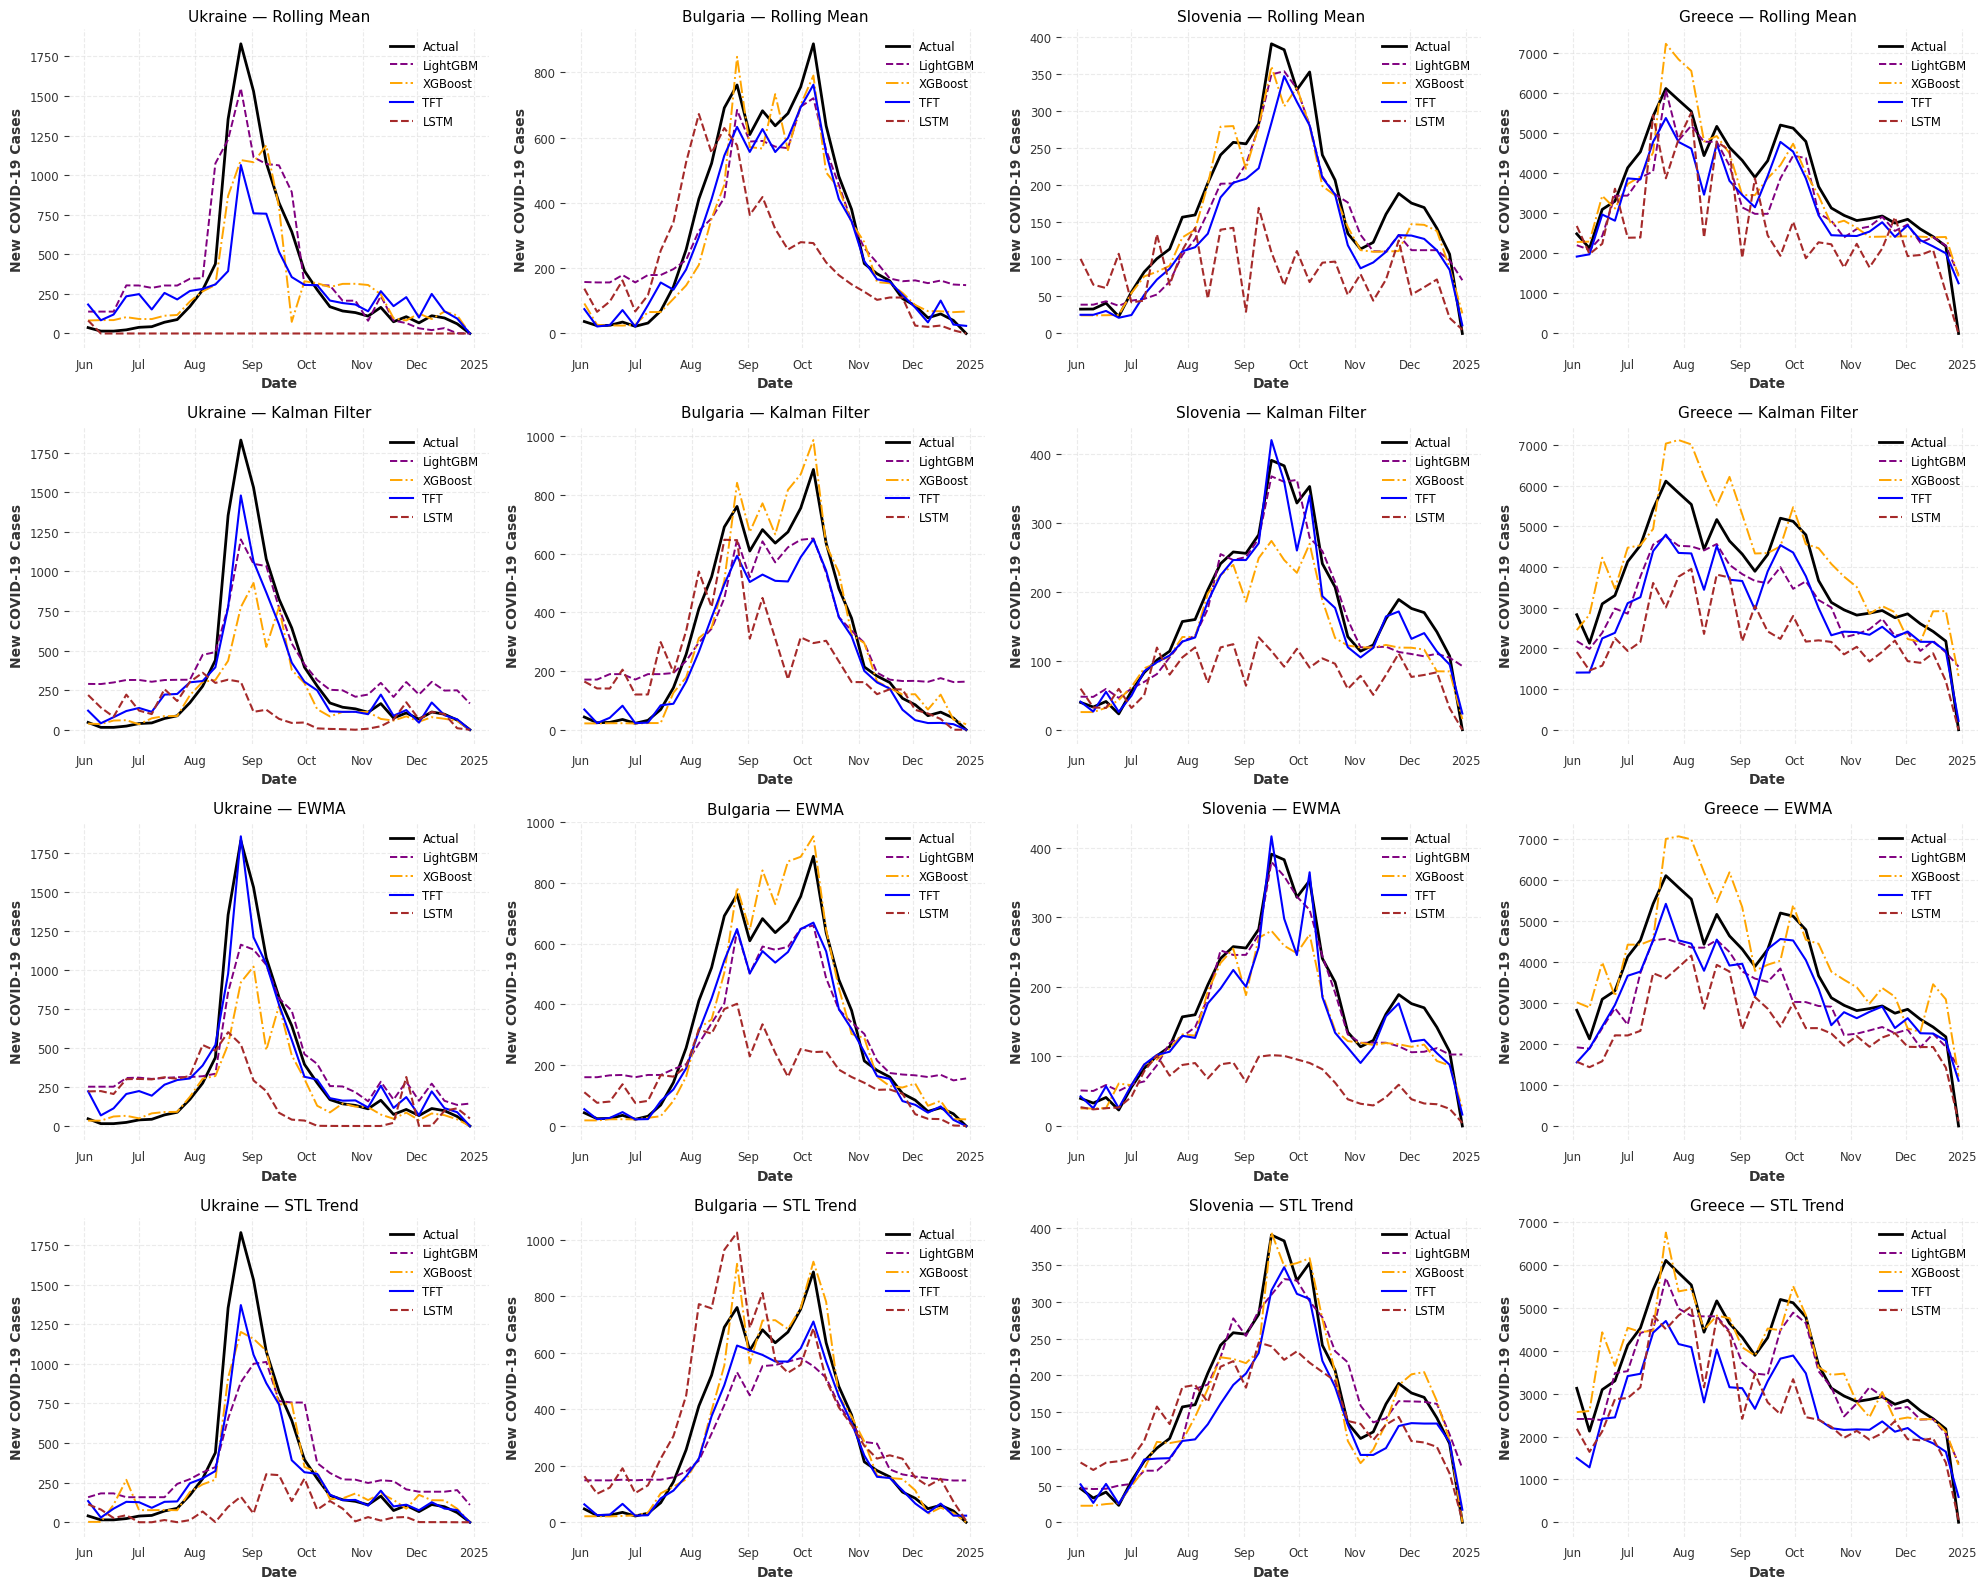

In [12]:
# =====================================================
# Model Comparison across Smoothing Methods and Countries (6-month experiments)
# =====================================================

countries = ["Ukraine", "Bulgaria", "Slovenia", "Greece"]
all_results = []

rows = len(smoothing_methods)
cols = len(countries)

# Load and preprocess WHO data
df = pd.read_csv("WHO-COVID-19-global-daily-data.csv")
df["Country_code"].fillna("Unknown", inplace=True)
df["New_cases"].fillna(0, inplace=True)
df["New_deaths"].fillna(0, inplace=True)
df["New_cases"] = df["New_cases"].clip(lower=0)
df["New_deaths"] = df["New_deaths"].clip(lower=0)

# Experiment parameters
split_date = "2024-06-03"
input_chunk_length = 48
forecast_horizon = 24

# Prepare visualization grid (safe creation)
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
if rows == 1:
    axes = np.array([axes])
if cols == 1:
    axes = axes.reshape(rows, 1)

for row_idx, (method_name, method_func) in enumerate(smoothing_methods.items()):
    print(f"\n=== Smoothing method: {method_name} ===")

    for col_idx, country in enumerate(countries):
        print(f"Processing {country} with {method_name}...")

        # Filter and smooth country data
        df_country = df[df["Country"] == country].copy().reset_index(drop=True)
        df_country["Date_reported"] = pd.to_datetime(df_country["Date_reported"])
        train_df = df_country[df_country["Date_reported"] < split_date]
        test_df = df_country[df_country["Date_reported"] >= split_date]

        smoothed_train = train_df.copy()

        smoothed_values = method_func(train_df["New_cases"])
        if isinstance(smoothed_values, np.ndarray) and smoothed_values.ndim > 1:
            smoothed_values = smoothed_values.flatten()
        smoothed_train["New_cases"] = smoothed_values

        df_smoothed = pd.concat([smoothed_train, test_df]).sort_values(by="Date_reported")

        # Run forecasting models
        pred_tft, mape_tft, mae_tft, rmse_tft = tft_model(df_smoothed, split_date, country, input_chunk_length, forecast_horizon)
        pred_lstm, mape_lstm, mae_lstm, rmse_lstm = lstm_model(df_smoothed, split_date, country, input_chunk_length, forecast_horizon)
        pred_xgb, mape_xgb, mae_xgb, rmse_xgb = xgboost_model(df_smoothed, country, split_date)
        pred_lgb, mape_lgb, mae_lgb, rmse_lgb = lgb_model(df_smoothed, country, split_date)

        # Store metrics
        results = pd.DataFrame({
            "Model": ["XGBoost", "LightGBM", "TFT", "LSTM"],
            "RMSE": [rmse_xgb, rmse_lgb, rmse_tft, rmse_lstm],
            "MAE": [mae_xgb, mae_lgb, mae_tft, mae_lstm],
            "MAPE": [mape_xgb, mape_lgb, mape_tft, mape_lstm],
            "Smoothing Method": method_name,
            "Country": country
        })
        all_results.append(results)

        # Plot actual vs predictions
        test_plot_df = get_test_df(df_smoothed, country, split_date)
        ax = axes[row_idx, col_idx]

        ax.plot(test_plot_df["Date_reported"], test_plot_df["New_cases"], color="black", linewidth=2, label="Actual")
        ax.plot(test_plot_df["Date_reported"], pred_lgb, label="LightGBM", color="purple", linestyle="--", linewidth=1.4)
        ax.plot(test_plot_df["Date_reported"], pred_xgb, label="XGBoost", color="orange", linestyle="-.", linewidth=1.4)
        
        if isinstance(pred_tft, pd.Series):
            ax.plot(test_df['Date_reported'], pred_tft, label="TFT", color="blue", linestyle='solid', linewidth=1.5)
        else:
            pred_tft.plot(ax=ax, label="TFT", color="blue", linestyle='solid', linewidth=1.5, low_quantile=None, high_quantile=None)

        if isinstance(pred_lstm, pd.Series):
            ax.plot(test_df['Date_reported'], pred_lstm, label="LSTM", color='brown', linestyle='dashed', linewidth=1.5)
        else:
            pred_lstm.plot(ax=ax, label="LSTM", color="brown", linestyle='dashed', linewidth=1.5)

        ax.set_title(f"{country} — {method_name}", fontsize=11)
        ax.set_xlabel("Date")
        ax.set_ylabel("New COVID-19 Cases")
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend(fontsize="small")

# Save results
df_results = pd.concat(all_results, ignore_index=True)
df_results.to_csv("smoothing_methods_four_countries.csv", index=False)

plt.tight_layout()
plt.show()


## Heatmap Visualization (6-Month Forecasting)

This section visualizes model performance across smoothing methods and countries
using heatmaps for **RMSE**, **MAE**, and **MAPE** metrics.

- Loads results from `smoothing_methods_four_contries.csv`  
- Ensures numeric metrics and removes missing values  
- Uses scientific notation (with superscript) for MAPE values  
- Displays 2D heatmaps comparing models and smoothing methods for each country  
- Saves figure as `heatmaps_6_m_superscript.png`


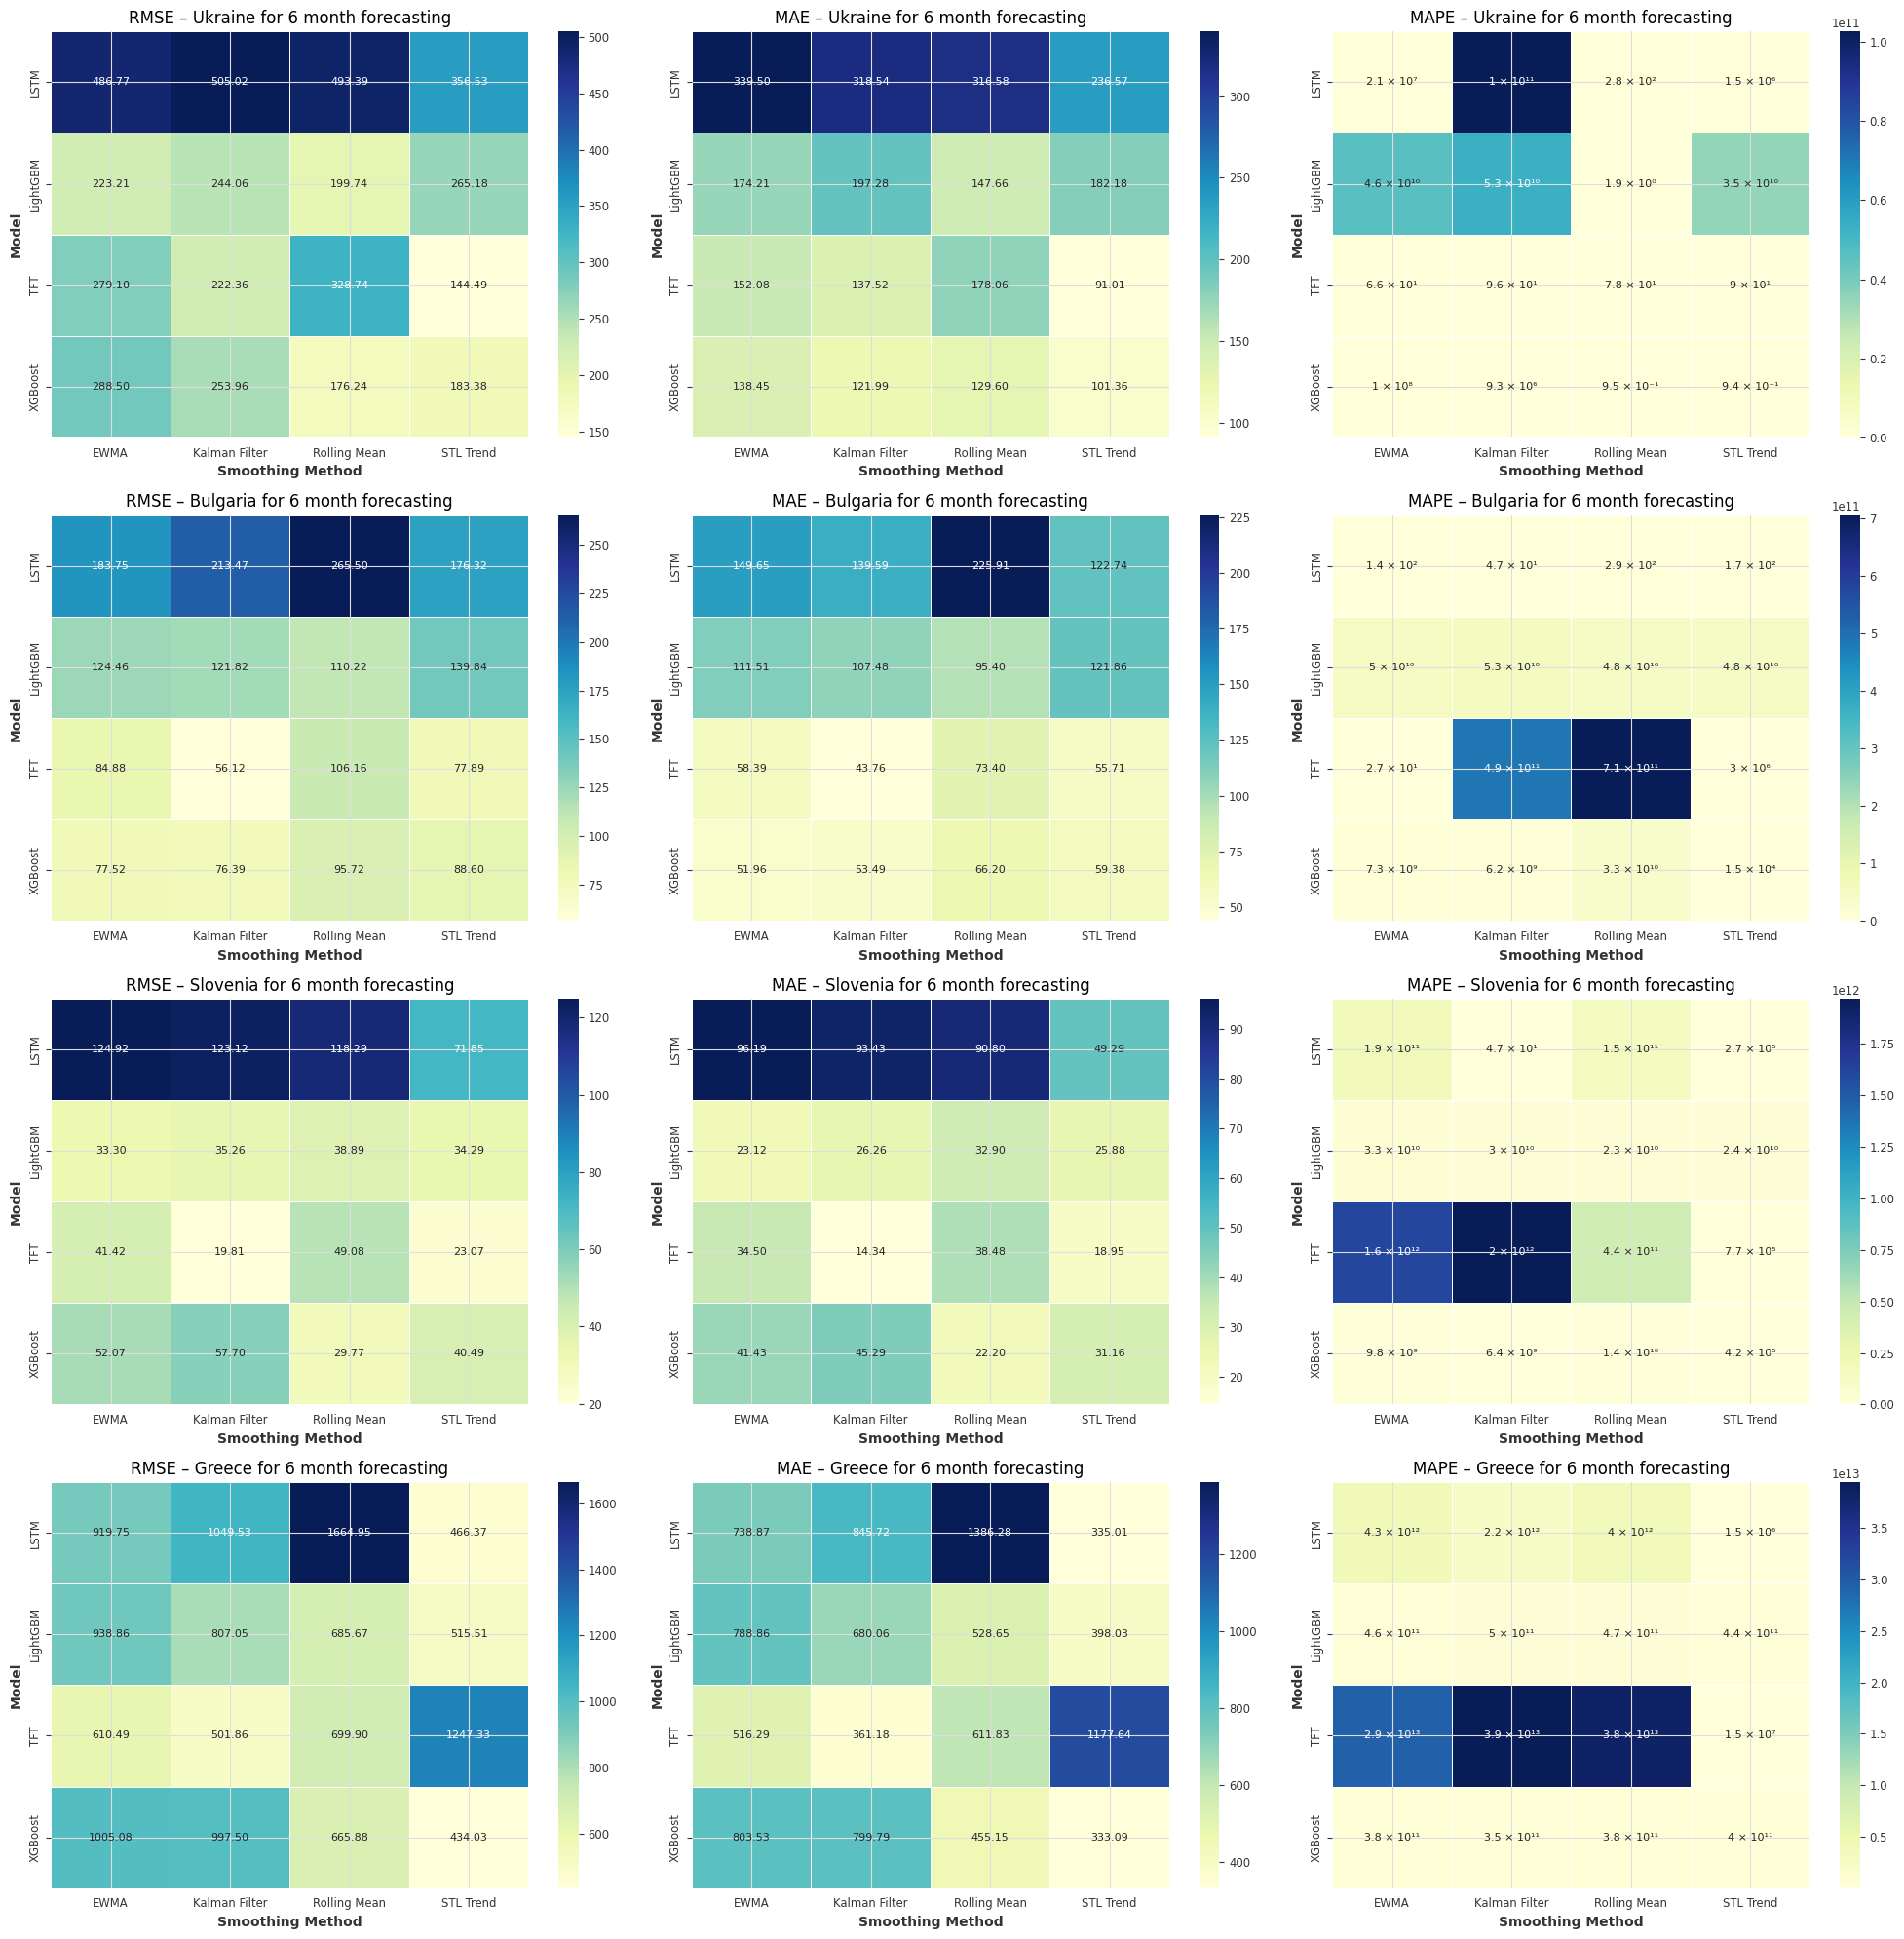

In [11]:
# === Heatmaps of Forecasting Metrics (6-Month Horizon) ===

# Load and preprocess data
df = pd.read_csv("E:\Covid\smoothing_methods_four_contries.csv")

## Ensure metrics are numeric
for col in ['RMSE', 'MAE', 'MAPE']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing metric values
df.dropna(subset=['RMSE', 'MAE', 'MAPE'], inplace=True)

# Define layout
metrics = ['RMSE', 'MAE', 'MAPE']
countries = df['Country'].unique()

# Create a larger plot area
fig, axes = plt.subplots(nrows=len(countries), ncols=3, figsize=(20, 5 * len(countries)))

# Function to format numbers in "× 10ⁿ" format with superscript
def sci_fmt(x):
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(x))))
    coeff = x / (10 ** exponent)
    superscript_map = str.maketrans("0123456789-", "⁰¹²³⁴⁵⁶⁷⁸⁹⁻")
    exponent_str = str(exponent).translate(superscript_map)
    return f"{coeff:.2g} × 10{exponent_str}"

# Plot each heatmap
for i, country in enumerate(countries):
    for j, metric in enumerate(metrics):
        ax = axes[i, j] if len(countries) > 1 else axes[j]

        pivot_table = df[df['Country'] == country].pivot_table(
            index='Model',
            columns='Smoothing Method',
            values=metric,
            aggfunc='mean'
        )

        if metric == 'MAPE':
            annot_labels = np.vectorize(sci_fmt)(pivot_table.values)
            sns.heatmap(
                pivot_table,
                annot=annot_labels,
                fmt='',
                cmap="YlGnBu",
                linewidths=0.5,
                ax=ax,
                annot_kws={"size": 8}
            )
        else:
            sns.heatmap(
                pivot_table,
                annot=True,
                fmt=".2f",
                cmap="YlGnBu",
                linewidths=0.5,
                ax=ax,
                annot_kws={"size": 8}
            )

        ax.set_title(f'{metric} – {country} for 6 month forecasting', fontsize=12)
        ax.set_ylabel('Model')
        ax.set_xlabel('Smoothing Method')

plt.tight_layout()
# Save the plot if needed
plt.savefig('heatmaps_6_m_superscript.png', dpi=600)
plt.show()


### Boxplot Comparison of Smoothing Methods (6-Month Forecast)
Distribution of RMSE, MAE, and log-scaled MAPE across all models to assess error variability under different smoothing techniques.


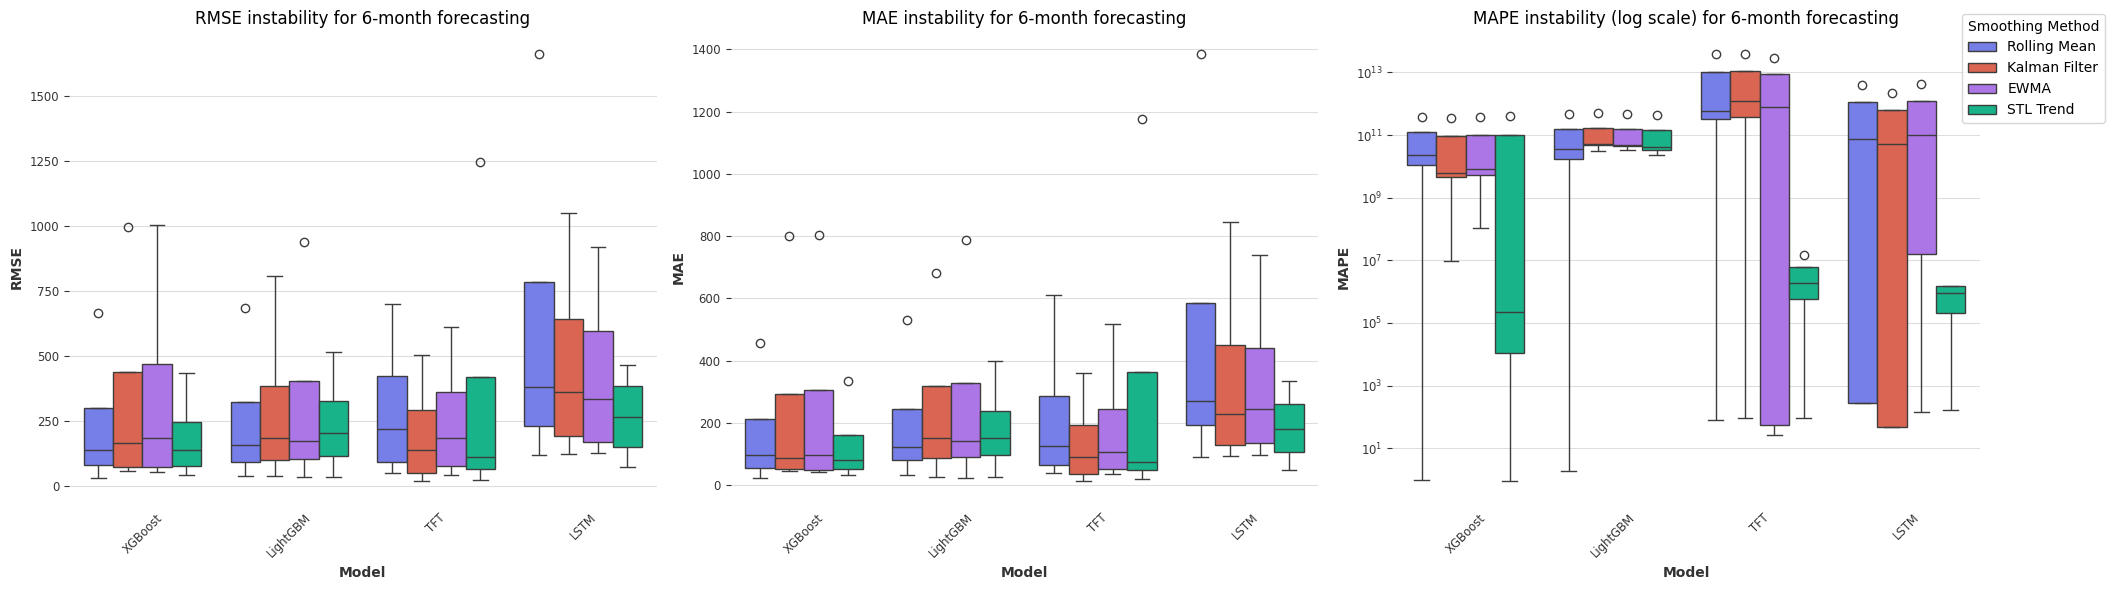

In [12]:
# === Boxplots of Model Instability (6-Month Forecasting) ===

custom_palette = {
    "Rolling Mean": "#636EFA",   # Deep blue (Plotly)
    "Kalman Filter": "#EF553B",  # Red-orange
    "EWMA": "#AB63FA",           # Purple
    "STL Trend": "#00CC96"       # Green-teal
}

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- RMSE ---
sns.boxplot(
    data=df, x="Model", y="RMSE", hue="Smoothing Method",
    ax=axes[0], palette=custom_palette
)
axes[0].set_title("RMSE instability for 6-month forecasting")
axes[0].set_xlabel("Model")
axes[0].set_ylabel("RMSE")
axes[0].tick_params(axis="x", rotation=45)
axes[0].legend_.remove()

# --- MAE ---
sns.boxplot(
    data=df, x="Model", y="MAE", hue="Smoothing Method",
    ax=axes[1], palette=custom_palette
)
axes[1].set_title("MAE instability for 6-month forecasting")
axes[1].set_xlabel("Model")
axes[1].set_ylabel("MAE")
axes[1].tick_params(axis="x", rotation=45)
axes[1].legend_.remove()

# --- MAPE ---
sns.boxplot(
    data=df, x="Model", y="MAPE", hue="Smoothing Method",
    ax=axes[2], palette=custom_palette
)
axes[2].set_title("MAPE instability (log scale) for 6-month forecasting")
axes[2].set_xlabel("Model")
axes[2].set_ylabel("MAPE")
axes[2].set_yscale("log")
axes[2].tick_params(axis="x", rotation=45)
axes[2].legend_.remove()

# --- Layout and Legend ---
plt.tight_layout()
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="upper left",
    bbox_to_anchor=(0.98, 0.98),
    title="Smoothing Method",
    frameon=True
)

plt.savefig(
    "E:/Covid/Paper smoothing methods/images/boxplots_6_m.png",
    dpi=600,
    bbox_inches="tight"
)
plt.show()


## Model Evaluation across Smoothing Techniques and Countries (3-Month Experiments)

This section presents a complementary **short-term forecasting experiment** over a 3-month horizon, designed to compare the stability of smoothing methods in shorter predictive intervals.

### Experiment Setup
- **Countries:** Ukraine, Bulgaria, Slovenia, and Greece  
- **Smoothing Methods:** Rolling Mean, EWMA, Kalman Filter, STL Trend  
- **Forecasting Models:**  
  - XGBoost  
  - LightGBM  
  - LSTM (RNN-based)  
  - Temporal Fusion Transformer (TFT)
- **Training window:** All available data before *September 30, 2024*  
- **Forecast horizon:** 12 weeks (≈ 3 months)  
- **Evaluation metrics:** RMSE, MAE, MAPE  

### Procedure
1. Load and preprocess WHO daily COVID-19 data (fill missing values, remove negatives).  
2. For each **smoothing method**, smooth the training segment of each country’s time series and merge it with the unsmoothed test segment.  
3. For each **country**:
   - Train the four forecasting models.  
   - Compute and record performance metrics (RMSE, MAE, MAPE).  
   - Plot actual vs. predicted weekly case counts.  
4. Aggregate all metrics into a single results file:  
   `smoothing_methods_four_contries_3_monthes.csv`.

### Visualization
Each **row** of subplots corresponds to a smoothing method, and each **column** to a country.  
The plots display actual versus predicted case dynamics, revealing how smoothing affects model accuracy in **short-term (3-month) forecasting**.


Smoothing method: Rolling Mean
Processing Ukraine with Rolling Mean...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Bulgaria with Rolling Mean...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Slovenia with Rolling Mean...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Greece with Rolling Mean...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Smoothing method: Kalman Filter
Processing Ukraine with Kalman Filter...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Bulgaria with Kalman Filter...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Slovenia with Kalman Filter...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Greece with Kalman Filter...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Smoothing method: EWMA
Processing Ukraine with EWMA...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Bulgaria with EWMA...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Slovenia with EWMA...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Greece with EWMA...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Smoothing method: STL Trend
Processing Ukraine with STL Trend...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Bulgaria with STL Trend...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Slovenia with STL Trend...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Greece with STL Trend...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

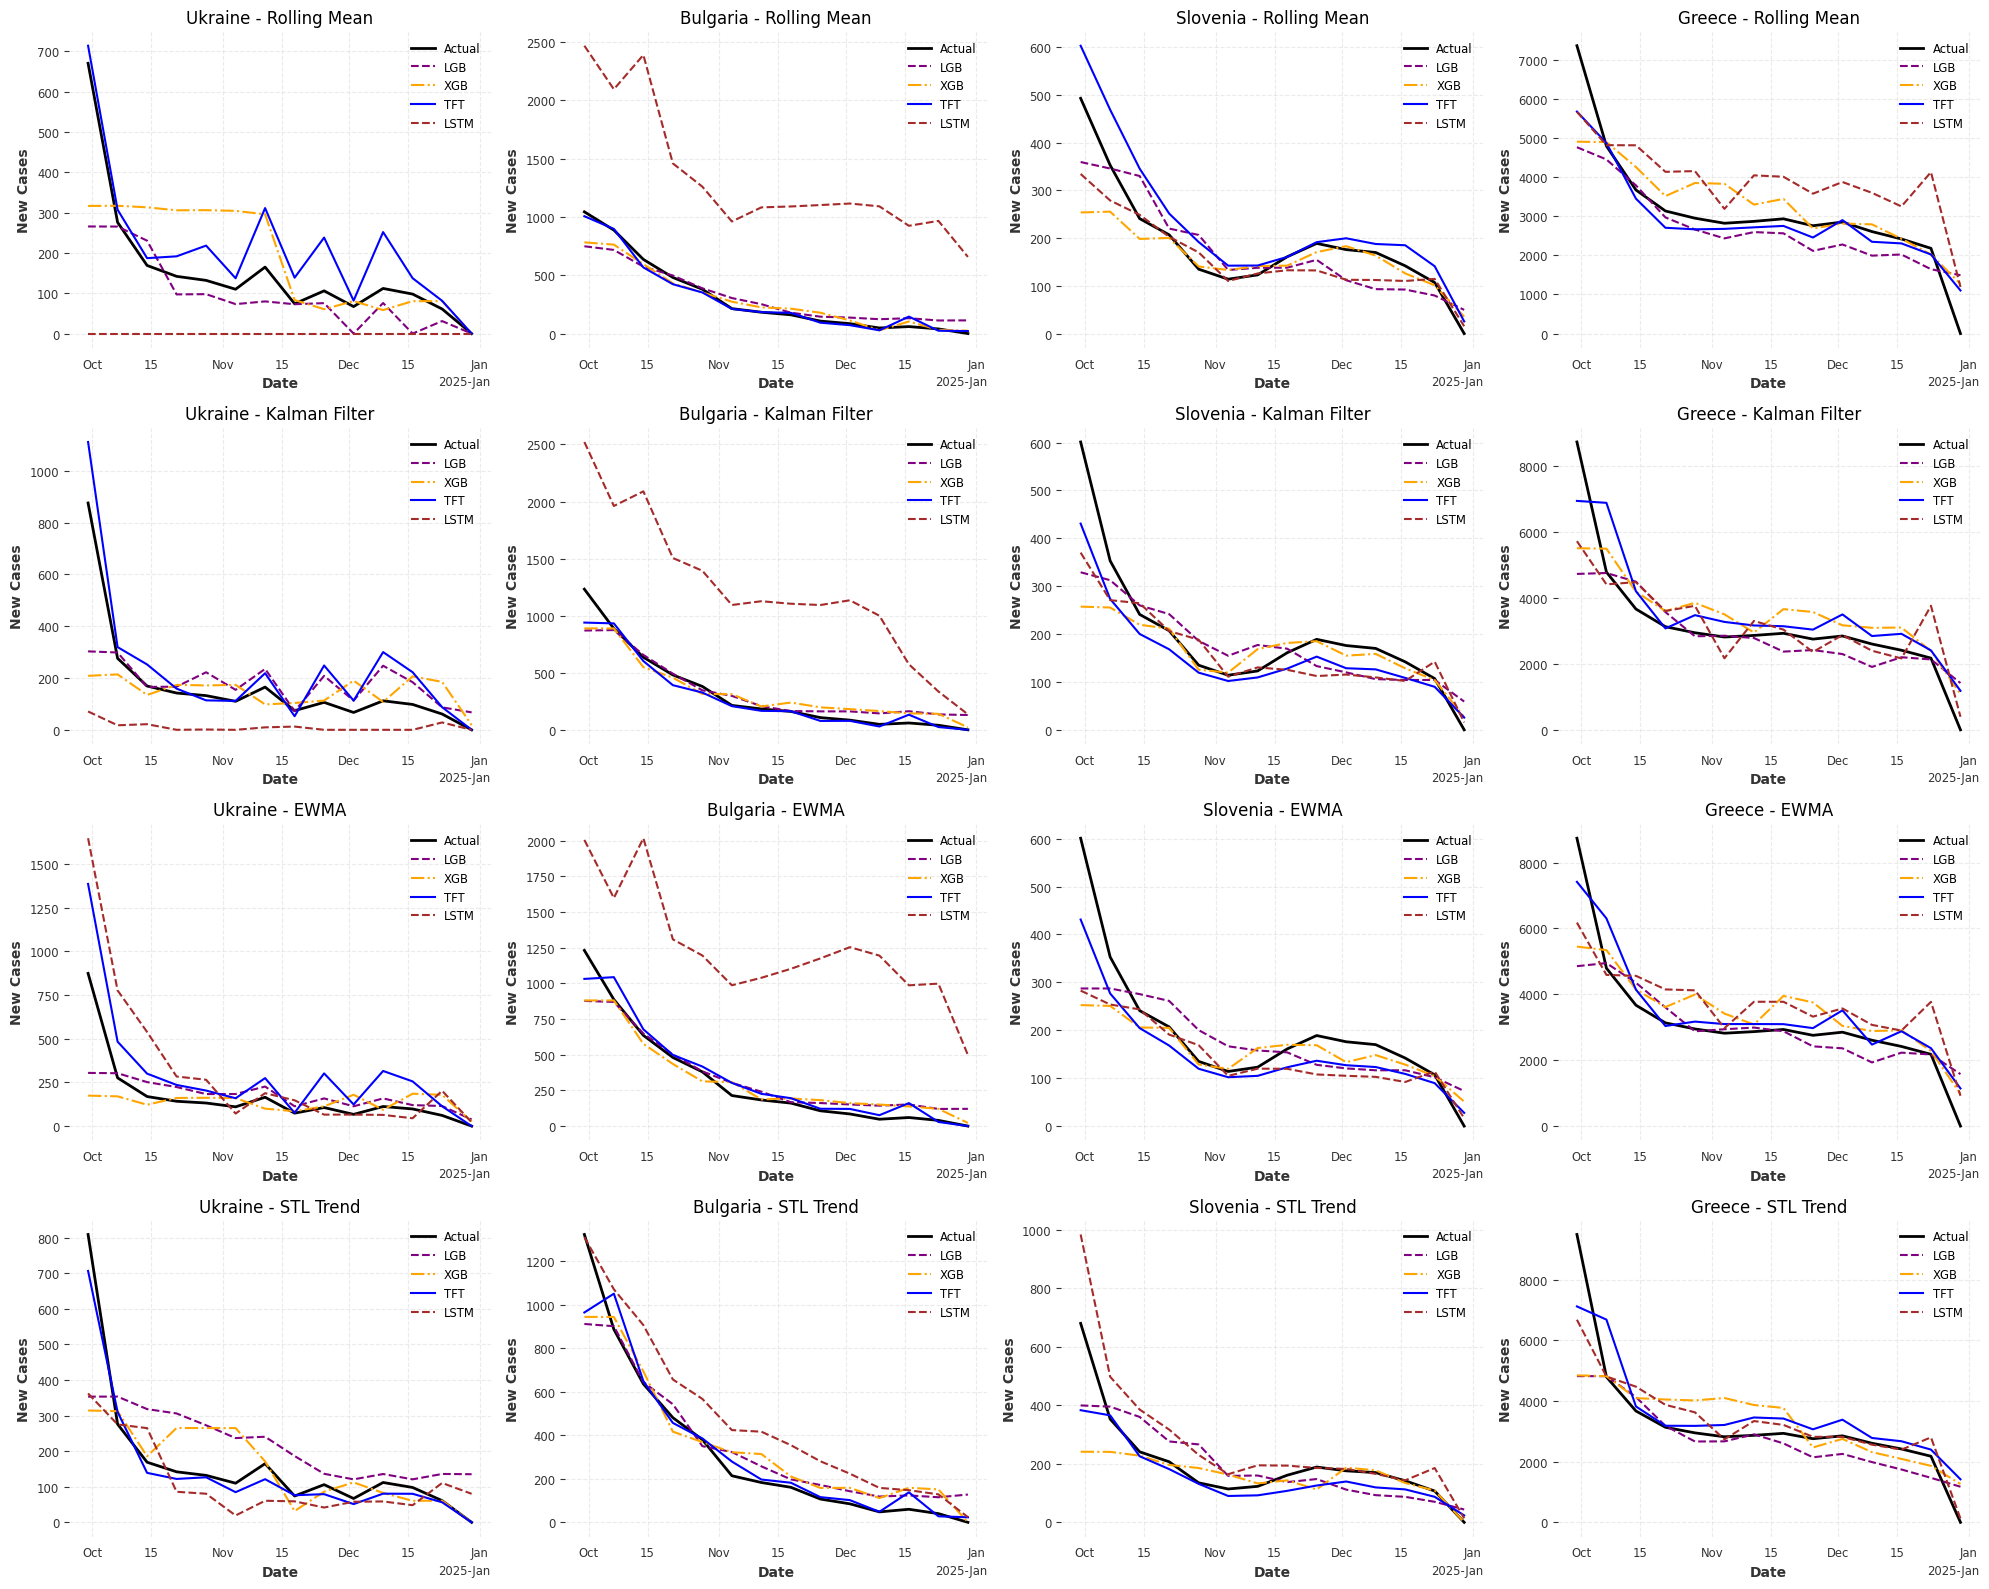

In [13]:

countries = ['Ukraine', 'Bulgaria', 'Slovenia', 'Greece']
all_results = []

# Number of rows = number of smoothing methods
rows = len(smoothing_methods)
cols = len(countries)  # Always 4

# Load and preprocess data
df = pd.read_csv('WHO-COVID-19-global-daily-data.csv')
df['Country_code'].fillna('Unknown', inplace=True)
df['New_cases'].fillna(0, inplace=True)  
df['New_deaths'].fillna(0, inplace=True)
df['New_cases'] = df['New_cases'].clip(lower=0)
df['New_deaths'] = df['New_deaths'].clip(lower=0)

split_date = "2024-09-30"
input_chunk_length = 48  
forecast_horizon = 12

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharex=False)
if rows == 1:
    axes = [axes]  # Ensure 2D-like indexing for a single row
elif cols == 1:
    axes = [[ax] for ax in axes]  # Ensure 2D indexing for a single column

for row_idx, (method_name, method_func) in enumerate(smoothing_methods.items()):
    print('Smoothing method:', method_name)
    
    for col_idx, country in enumerate(countries):
        print(f"Processing {country} with {method_name}...")

        df_country = df[df['Country'] == country].reset_index(drop=True)
        train_df = df_country[df_country['Date_reported'] < split_date]
        test_data = df_country[df_country['Date_reported'] >= split_date]

        train_df2 = train_df.copy()
        train_df2['New_cases'] = method_func(train_df['New_cases'])
        df_new = pd.concat([train_df2, test_data]).sort_values(by='Date_reported')

        # Run forecasting models
        pred_tft, mape_score, mae_score, rmse_score = tft_model(df_new, split_date, country, input_chunk_length, forecast_horizon)
        pred_xgb, mape_score_xgb, mae_score_xgb, rmse_score_xgb = xgboost_model(df_new, country, split_date)
        pred_lgb, mape_score_lgb, mae_score_lgb, rmse_score_lgb = lgb_model(df_new, country, split_date)
        pred_lstm, mape_score_lstm, mae_score_lstm, rmse_score_lstm = lstm_model(df_new, split_date, country, input_chunk_length, forecast_horizon)

        # Store results
        results = pd.DataFrame({
            'Model': ['XGBoost', 'LightGBM', 'TFT', "LSTM"],
            'RMSE': [rmse_score_xgb, rmse_score_lgb, rmse_score, rmse_score_lstm],
            'MAE': [mae_score_xgb, mae_score_lgb, mae_score, mae_score_lstm],
            'MAPE': [mape_score_xgb, mape_score_lgb, mape_score, mape_score_lstm]
        })
        results['Smoothing Method'] = method_name  
        results['Country'] = country
        all_results.append(results)

        test_df = get_test_df(df_new, country, split_date)
        ax = axes[row_idx][col_idx]

        # Plot
        ax.plot(test_df['Date_reported'], test_df['New_cases'], linewidth=2, label='Actual', color='black')
        ax.plot(test_df['Date_reported'], pred_lgb, label='LGB', color='purple', linestyle='--', linewidth=1.5)
        ax.plot(test_df['Date_reported'], pred_xgb, label='XGB', color='orange', linestyle='-.', linewidth=1.5)


        if isinstance(pred_tft, pd.Series):
            ax.plot(test_df['Date_reported'], pred_tft, label="TFT", color="blue", linestyle='solid', linewidth=1.5)
        else:
            pred_tft.plot(ax=ax, label="TFT", color="blue", linestyle='solid', linewidth=1.5, low_quantile=None, high_quantile=None)

        if isinstance(pred_lstm, pd.Series):
            ax.plot(test_df['Date_reported'], pred_lstm, label="LSTM", color='brown', linestyle='dashed', linewidth=1.5)
        else:
            pred_lstm.plot(ax=ax, label="LSTM", color="brown", linestyle='dashed', linewidth=1.5)

        ax.set_title(f'{country} - {method_name}')
        ax.set_xlabel('Date')
        ax.set_ylabel('New Cases')
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(fontsize='small')

# Save and export results
df_results = pd.concat(all_results, ignore_index=True)
df_results['MAPE'] = df_results['MAPE'].apply(lambda x: f'{x:.6f}') 
df_results.to_csv("smoothing_methods_four_contries_3_monthes.csv", index=False)

plt.tight_layout()
plt.show()


## 🧊 Heatmaps of 3-Month Forecasting Performance

This block visualizes **average RMSE, MAE, and MAPE** for each smoothing method across the four analyzed countries.  
Each heatmap shows how models (XGBoost, LightGBM, LSTM, TFT) performed under different smoothing strategies during the **3-month forecasting horizon**.

- Columns → Smoothing Methods  
- Rows → Forecasting Models  
- Annotations → Mean metric values (MAPE in scientific notation)  

The resulting plots are saved as `heatmaps_3_m.png`.


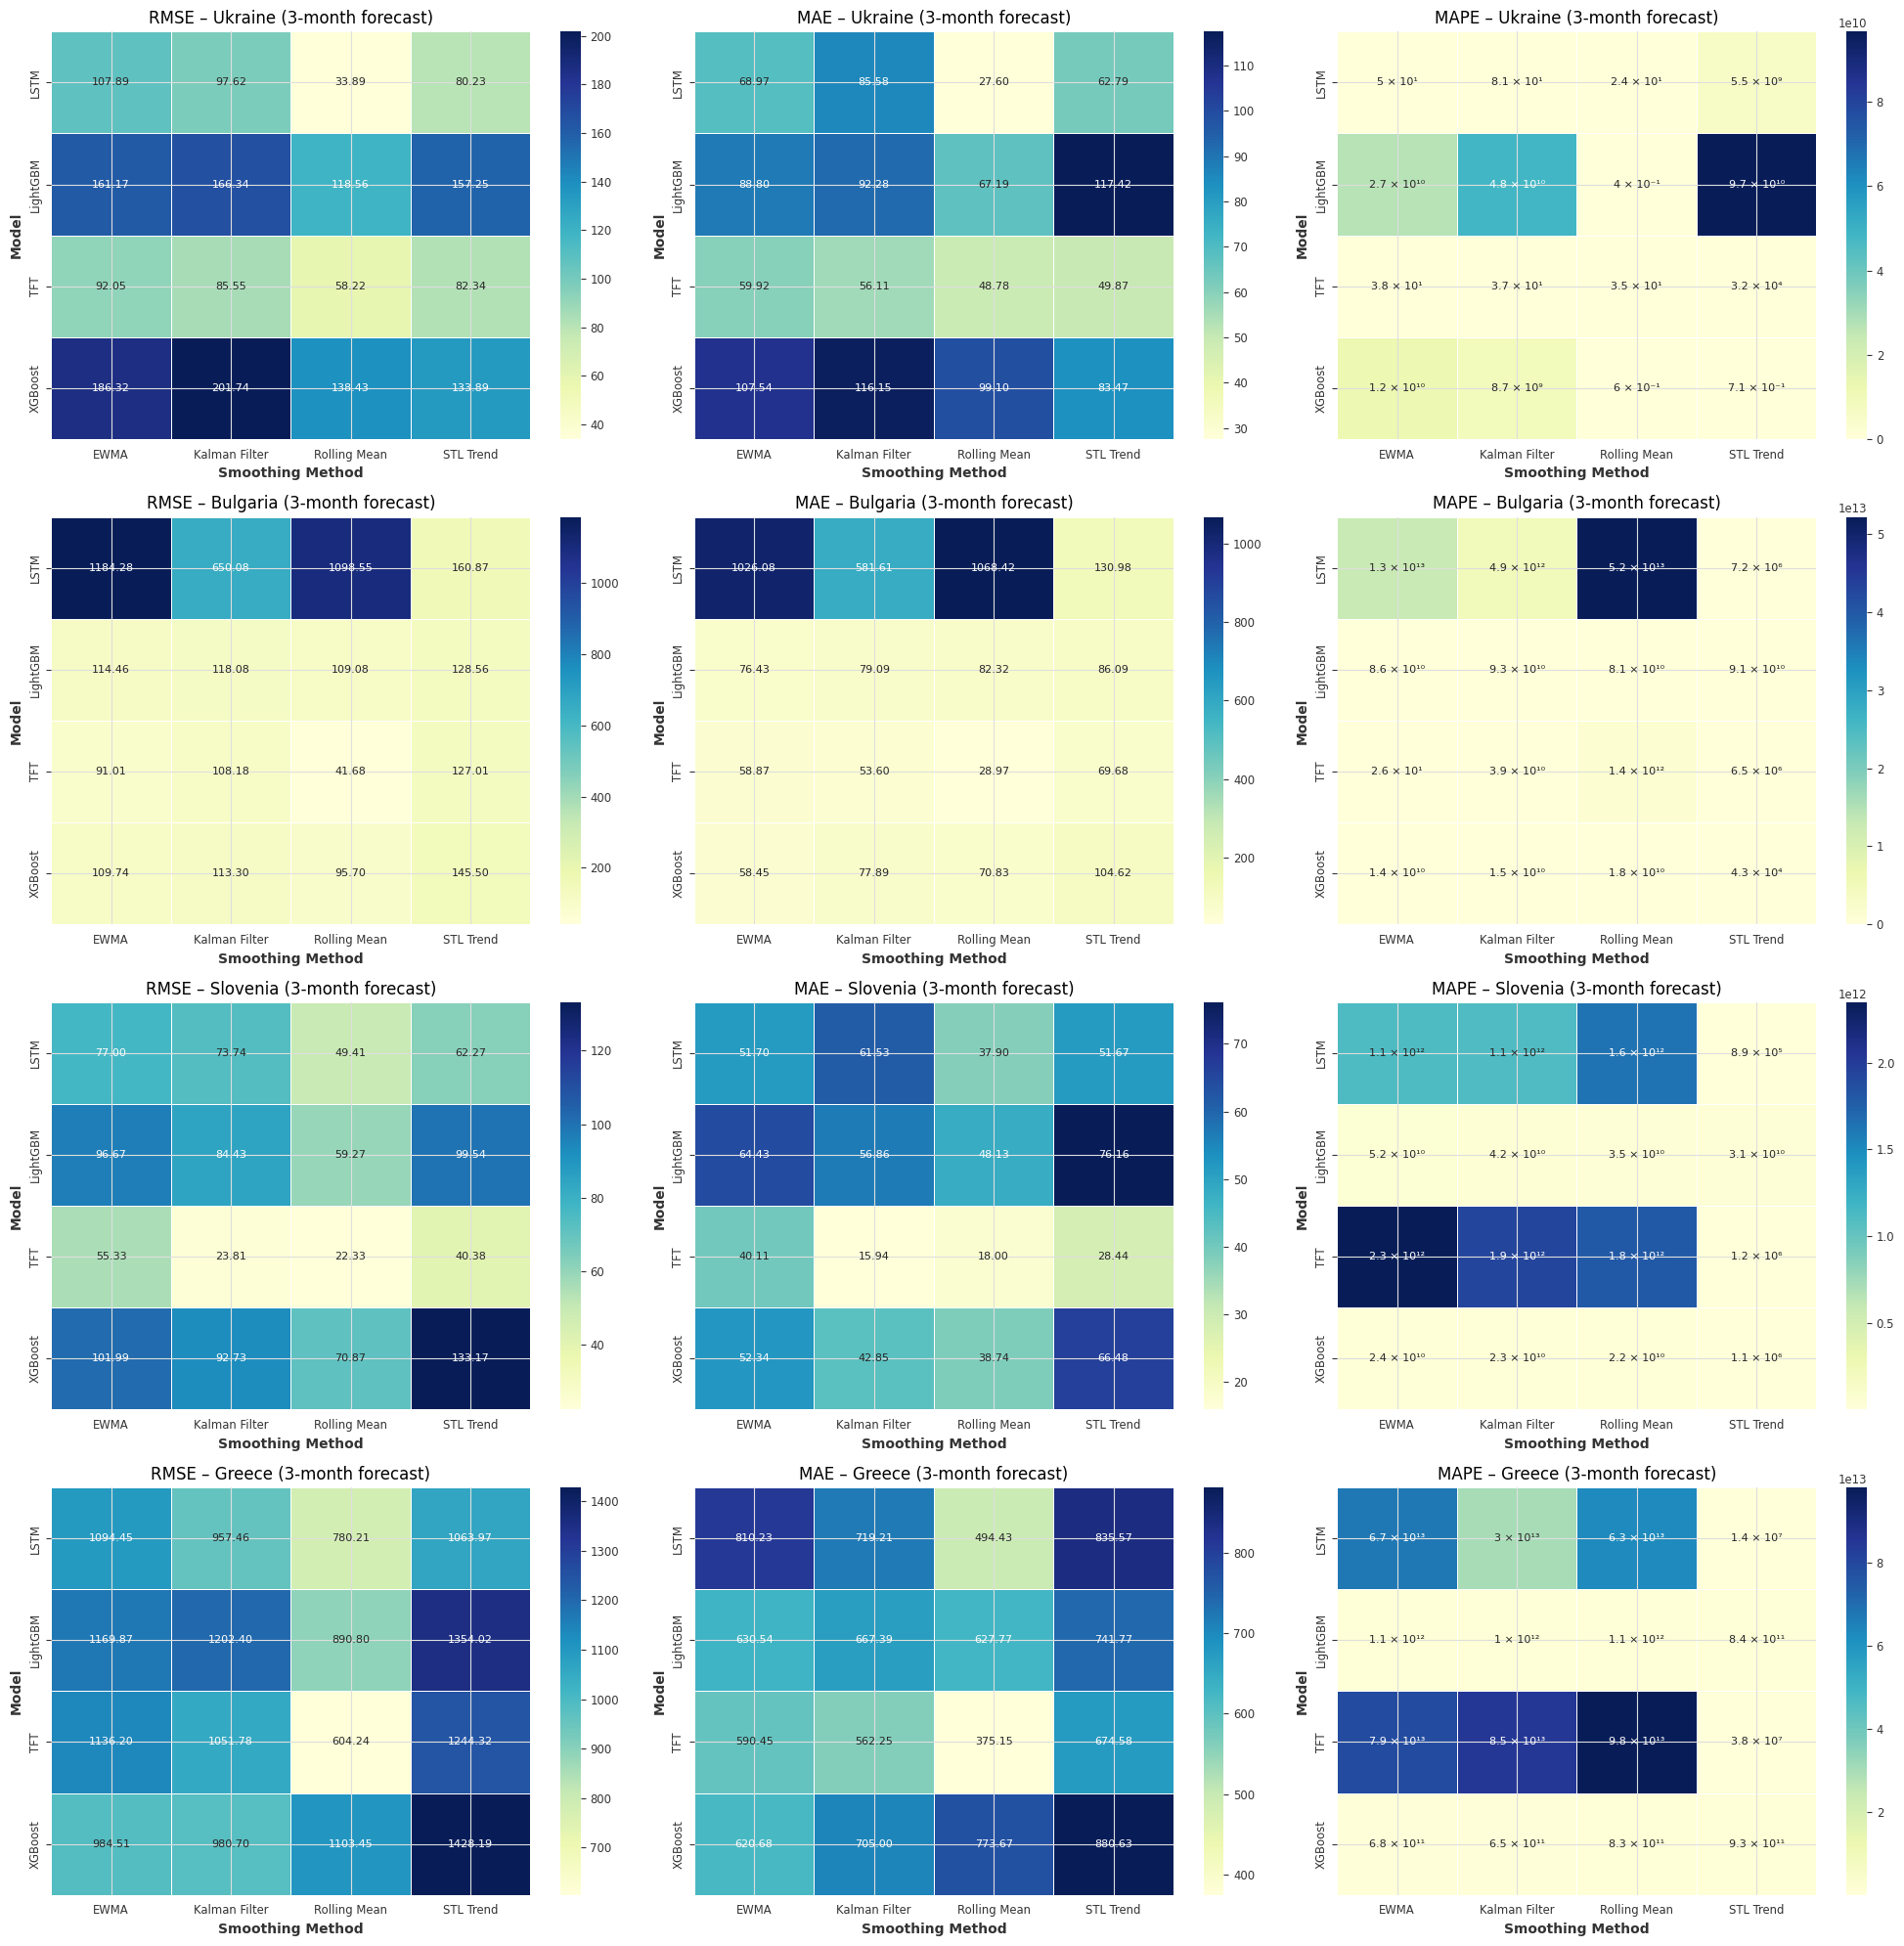

In [14]:
# === Heatmap Visualization for 3-Month Forecasting Results ===

# Load data
df_3 = pd.read_csv("E:\Covid\smoothing_methods_four_contries_3_monthes.csv")

# Ensure metrics are numeric
for col in ["RMSE", "MAE", "MAPE"]:
    df_3[col] = pd.to_numeric(df_3[col], errors="coerce")

# Drop rows with missing metric values
df_3.dropna(subset=["RMSE", "MAE", "MAPE"], inplace=True)

# Define layout
metrics = ["RMSE", "MAE", "MAPE"]
countries = df_3["Country"].unique()

# Create a larger plot area
fig, axes = plt.subplots(
    nrows=len(countries),
    ncols=3,
    figsize=(20, 5 * len(countries))
)

# Function for scientific notation with superscript exponent
def sci_fmt(x):
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(x))))
    coeff = x / (10 ** exponent)
    superscript_map = str.maketrans("0123456789-", "⁰¹²³⁴⁵⁶⁷⁸⁹⁻")
    exponent_str = str(exponent).translate(superscript_map)
    return f"{coeff:.2g} × 10{exponent_str}"

# Plot each heatmap
for i, country in enumerate(countries):
    for j, metric in enumerate(metrics):
        ax = axes[i, j] if len(countries) > 1 else axes[j]

        pivot_table = (
            df_3[df_3["Country"] == country]
            .pivot_table(
                index="Model",
                columns="Smoothing Method",
                values=metric,
                aggfunc="mean"
            )
        )

        if metric == "MAPE":
            annot_labels = np.vectorize(sci_fmt)(pivot_table.values)
            sns.heatmap(
                pivot_table,
                annot=annot_labels,
                fmt="",
                cmap="YlGnBu",
                linewidths=0.5,
                ax=ax,
                annot_kws={"size": 8}
            )
        else:
            sns.heatmap(
                pivot_table,
                annot=True,
                fmt=".2f",
                cmap="YlGnBu",
                linewidths=0.5,
                ax=ax,
                annot_kws={"size": 8}
            )

        ax.set_title(f"{metric} – {country} (3-month forecast)", fontsize=12)
        ax.set_ylabel("Model")
        ax.set_xlabel("Smoothing Method")

plt.tight_layout()
plt.savefig("heatmaps_3_m.png", dpi=600)
plt.show()


## 📦 Model Error Distribution (3-Month Horizon)

Boxplots show **RMSE**, **MAE**, and **MAPE** variability across models and smoothing methods  
for 3-month forecasts, highlighting performance stability and error dispersion.


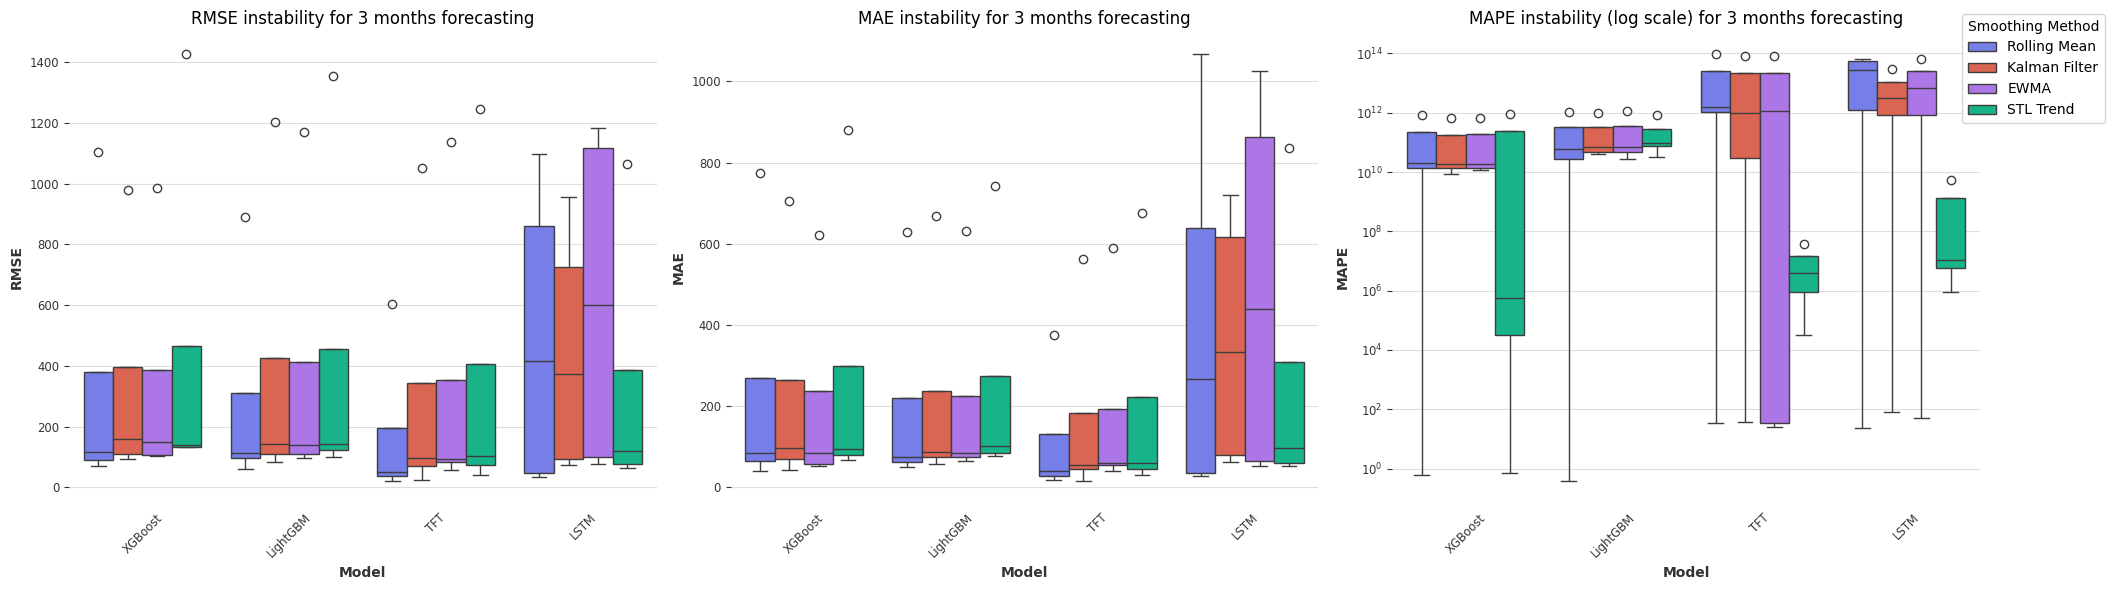

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
custom_palette = {
    'Rolling Mean': '#636EFA',     # deep blue (Plotly blue)
    'Kalman Filter': '#EF553B',    # red-orange
    'EWMA': '#AB63FA',             # purple
    'STL Trend': '#00CC96'         # green-teal
}
# --- RMSE ---
sns.boxplot(data=df_3, x='Model', y='RMSE', hue='Smoothing Method', ax=axes[0], palette=custom_palette)
axes[0].set_title('RMSE instability for 3 months forecasting')
axes[0].set_ylabel('RMSE')
axes[0].set_xlabel('Model')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend_.remove()  # Remove individual legend

# --- MAE ---
sns.boxplot(data=df_3, x='Model', y='MAE', hue='Smoothing Method', ax=axes[1], palette=custom_palette)
axes[1].set_title('MAE instability for 3 months forecasting')
axes[1].set_ylabel('MAE')
axes[1].set_xlabel('Model')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend_.remove()

# --- MAPE ---
sns.boxplot(data=df_3, x='Model', y='MAPE', hue='Smoothing Method', ax=axes[2], palette=custom_palette)
axes[2].set_title('MAPE instability (log scale) for 3 months forecasting')
axes[2].set_ylabel('MAPE')
axes[2].set_xlabel('Model')
axes[2].set_yscale('log')
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend_.remove()

# Adjust layout
plt.tight_layout()

# Shared legend in upper right
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='upper left',
    bbox_to_anchor=(0.98, 0.98),
    title='Smoothing Method',
    frameon=True
)

plt.show()


## ⚖️ Statistical Analysis of Model Performance

This section performs statistical testing to determine whether differences in forecasting accuracy across **smoothing methods** and **models** are significant.

### Methods Used
1. **Kruskal–Wallis Test** — non-parametric test used to check if MAPE distributions differ among smoothing methods.  
2. **Two-Way ANOVA** — evaluates the influence of:
   - `SmoothingMethod` (Rolling Mean, EWMA, Kalman Filter, STL Trend)  
   - `Model` (XGBoost, LightGBM, LSTM, TFT)  
   on forecasting accuracy across all datasets (3-month and 6-month horizons).  

### Metrics Tested
- **RMSE** – Root Mean Squared Error  
- **MAE** – Mean Absolute Error  
- **MAPE** – Mean Absolute Percentage Error  

### Output
The resulting table `combined_anova` summarizes **F-statistics** and **p-values** for each metric, indicating whether model type or smoothing method has a statistically significant impact on forecasting errors.


In [17]:
# === Load and prepare datasets ===
df_6m = pd.read_csv("E:\Covid\smoothing_methods_four_contries.csv")
df_3m = pd.read_csv("E:\Covid\smoothing_methods_four_contries_3_monthes.csv")

# Add horizon labels
df_6m["Horizon"] = "6M"
df_3m["Horizon"] = "3M"

# Combine datasets
df_all = pd.concat([df_6m, df_3m], ignore_index=True)

# Clean and convert MAPE values
df_all = df_all[pd.to_numeric(df_all["MAPE"], errors="coerce").notnull()]
df_all["MAPE"] = df_all["MAPE"].astype(float)

# Stabilize variance via log transform
df_all["log_MAPE"] = np.log1p(df_all["MAPE"])

# Rename for consistency
df_all = df_all.rename(columns={"Smoothing Method": "SmoothingMethod"})


# === Kruskal–Wallis test (non-parametric) ===
groups = [g["MAPE"].values for _, g in df_all.groupby("SmoothingMethod")]
kruskal_stat, kruskal_p = kruskal(*groups)


# === Two-way ANOVA ===
two_way_model = ols("MAPE ~ C(SmoothingMethod) + C(Model)", data=df_all).fit()
two_way_anova = anova_lm(two_way_model, typ=2)

# Display results
kruskal_stat, kruskal_p, two_way_anova


(np.float64(11.33207667151163),
 np.float64(0.01005928469893796),
                           sum_sq     df         F    PR(>F)
 C(SmoothingMethod)  1.170251e+27    3.0  1.485828  0.221820
 C(Model)            3.250593e+27    3.0  4.127166  0.007965
 Residual            3.176690e+28  121.0       NaN       NaN)

In [18]:
# === Two-Way ANOVA Analysis Across Metrics ===

def run_anova(metric: str):
    """
    Run two-way ANOVA for the given metric to test the effects of
    SmoothingMethod and Model on forecasting performance.
    """
    model = ols(f"{metric} ~ C(SmoothingMethod) + C(Model)", data=df_all).fit()
    anova = anova_lm(model, typ=2)

    # Keep only relevant rows and columns
    return (
        anova.loc[["C(SmoothingMethod)", "C(Model)"], ["F", "PR(>F)"]]
        .rename(columns={"F": f"F_{metric}", "PR(>F)": f"p_{metric}"})
    )


# === Run ANOVA for each metric ===
anova_mape = run_anova("MAPE")
anova_mae = run_anova("MAE")
anova_rmse = run_anova("RMSE")

# === Combine into a single summary table ===
combined_anova = pd.concat([anova_mape, anova_mae, anova_rmse], axis=1)

# === Display the results ===
print(combined_anova)


                      F_MAPE    p_MAPE     F_MAE     p_MAE    F_RMSE    p_RMSE
C(SmoothingMethod)  1.485828  0.221820  0.095127  0.962599  0.082142  0.969634
C(Model)            4.127166  0.007965  1.978298  0.120824  1.065945  0.366255
